# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgbm
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
import time

In [2]:
np.random.seed(12345)

### Загрузка данных и их первичный анализ

In [3]:
data = pd.read_csv('/datasets/autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [5]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


***Вывод***

Посмотрев на данные уже можно делать выводы об их качестве. Столбцы "DateCrawled", "DateCreated" и "LastSeen" нужно перевести в тип DateTime. В столбцах "VehicleType", "FuelType", "GearBox" "NotRepaired", "Model" есть заметное количество пропусков, с которыми нужно будет как-то обойтись. Также видны аномалии в столбцах "RegistrationYear", "Power"(Слишком большие и слишком маленькие значения), "RegistrationMonth"(нулевого месяца не бывает).

### Удаление неиформативных строк

In [6]:
data = data.query("VehicleType == VehicleType | Gearbox == Gearbox | Model == Model | FuelType == FuelType | NotRepaired == NotRepaired")
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 352132 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          352132 non-null object
Price                352132 non-null int64
VehicleType          316879 non-null object
RegistrationYear     352132 non-null int64
Gearbox              334536 non-null object
Power                352132 non-null int64
Model                334664 non-null object
Kilometer            352132 non-null int64
RegistrationMonth    352132 non-null int64
FuelType             321474 non-null object
Brand                352132 non-null object
NotRepaired          283215 non-null object
DateCreated          352132 non-null object
NumberOfPictures     352132 non-null int64
PostalCode           352132 non-null int64
LastSeen             352132 non-null object
dtypes: int64(7), object(9)
memory usage: 45.7+ MB


Строчки, в которых 5 пропусков выглядят очень подозрительно, поэтому мы их удалим. Избавились от 0.5% мусора:)

### Работа с аномалиями

Все значения выглядят нормально, за исключением столбцов "RegistrationYear", "Power", "RegistrationMonth"

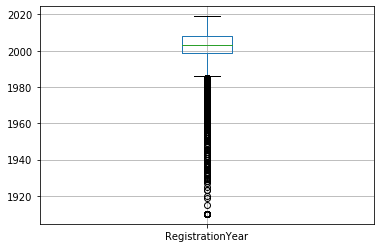

In [7]:
data = data.query("RegistrationYear < 2021 and RegistrationYear > 1900")
data[['RegistrationYear']].boxplot()
data = data.query("RegistrationYear > 1985")

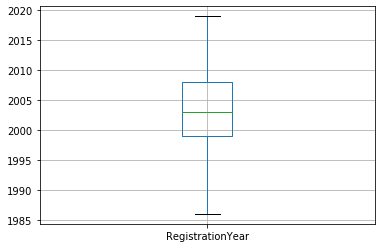

In [8]:
data[['RegistrationYear']].boxplot()

2021 выставили, так как машина не может быть зарегестрированна в будующем, а 1985 - по графику ящик с усами.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 345805 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          345805 non-null object
Price                345805 non-null int64
VehicleType          311459 non-null object
RegistrationYear     345805 non-null int64
Gearbox              329322 non-null object
Power                345805 non-null int64
Model                329445 non-null object
Kilometer            345805 non-null int64
RegistrationMonth    345805 non-null int64
FuelType             316352 non-null object
Brand                345805 non-null object
NotRepaired          278984 non-null object
DateCreated          345805 non-null object
NumberOfPictures     345805 non-null int64
PostalCode           345805 non-null int64
LastSeen             345805 non-null object
dtypes: int64(7), object(9)
memory usage: 44.9+ MB


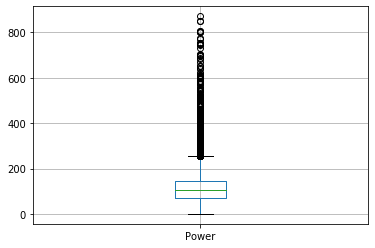

In [9]:
data = data.query("Power < 900")
data[['Power']].boxplot()
data.info()

Тут мы воспользуемся не ящиком с усами, а гуглом. Учитывая максимальную стоимость машин в нашей выборке мощность скорее всего не превышает 900 лошадиных сил, так как машины с большим количеством лошадиных сил имеют цену в 1000 000 $ и более, что скорее всего не продаётся за 200 000 евро.

Ссылка на топ самых мощных машин(Да он от 2018 года, но с boxplot мы уберём машины с мощностью выше, чем примерно 250, что явно не соответствует истине л.с.): https://zen.yandex.ru/media/auto_now/10-avto-s-samym-bolshim-kolvom-loshadinyh-sil-5b7c3fe9c88f9700a9bb620

In [10]:
data["RegistrationMonth"].value_counts()

0     34067
3     33754
6     30958
4     28770
5     28657
7     26498
10    25821
12    24044
11    23949
9     23480
1     22572
8     22339
2     20896
Name: RegistrationMonth, dtype: int64

### Работа с пропусками

#### NotRepaired

In [11]:
data['NotRepaired'].value_counts()

no     243549
yes     35435
Name: NotRepaired, dtype: int64

Заполним пропуски значением "no", так как это явных плюс при продаже и скорее люди пропустят это поле, если ответ может отпугнуть покупателя, чем если ответ его привлечёт. Также обычно б/у машины хоть как-то, да ремонтировались.

In [12]:
data['NotRepaired'] = data['NotRepaired'].fillna('no') 
data['NotRepaired'].value_counts()

no     310370
yes     35435
Name: NotRepaired, dtype: int64

#### VehicleType

In [13]:
data.VehicleType.value_counts()

sedan          89473
small          79252
wagon          64868
bus            28487
convertible    19499
coupe          15181
suv            11677
other           3022
Name: VehicleType, dtype: int64

Как мы видим у нас есть значение other, которое очень подходит для целей заполнения пропусков. По сути это и есть не указанный тип кузова. Так и заполним пропуски.

In [14]:
data['VehicleType'] = data["VehicleType"].fillna("other")
data["VehicleType"].unique()

array(['other', 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon'], dtype=object)

#### GearBox

In [15]:
data.groupby(by = "Gearbox")['Price'].mean()

Gearbox
auto      6821.951149
manual    3956.042897
Name: Price, dtype: float64

In [16]:
data.loc[data["Price"] < (3956 + 6821) / 2, "Gearbox"] = data.loc[data["Price"] < (3956 + 6821) / 2, "Gearbox"].fillna("manual")
data.loc[data["Price"] > (3956 + 6821) / 2, "Gearbox"] = data.loc[data["Price"] > (3956 + 6821) / 2, "Gearbox"].fillna("auto")

In [17]:
data.groupby(by = "Gearbox")['Price'].mean()

Gearbox
auto      6884.567428
manual    3822.470871
Name: Price, dtype: float64

Заполнили пропуски в зависимости от цены. Обычно машина с автоматической коробкой передач дороже, чем с механикой. После проверили изменение средних цен. Оно изменилось не сильно. Поэтому будем считать, что заполнили пропуски болле менее нормально.

#### Model

In [18]:
data["Model"].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'c_max',
       '3_reihe', 'passat', 'navara', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'other', 'c4', 'civic',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'ka', 'a1', 'insignia',
       'transporter', 'combo', 'focus', 'tt', 'a6', 'jazz', 'omega',
       'slk', '7er', '80', '147', 'z_reihe', 'sportage', 'sorento', 'v40',
       'ibiza', 'mustang', 'eos', 'touran', 'getz', 'a3', 'almera',
       'megane', 'lupo', 'r19', 'zafira', 'mondeo', 'cordoba', 'colt',
       'impreza', 'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace',
       'sharan', '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe',
       'yeti', 'octavia', 'mii', 'rx_reihe', 'modus', 'fox', 'matiz',
       'beet

Заполнять модель гиблое дело, так как их слишком много и разгадать куда что поставить - ещё один проект. Поэтому остаётся только удалить или поставить заглушку, как в случае с other. У нас довольно большая выборка и тут пропусков 5%, поэтому всё-таки удалим.

In [19]:
data = data.loc[~data["Model"].isna()]

#### FuelType

In [20]:
data["FuelType"].value_counts()

petrol      203459
gasoline     95393
lpg           4920
cng            539
hybrid         207
other          106
electric        65
Name: FuelType, dtype: int64

Тут у нас всё-таки 25 тысяч пропусков, что слабо стыкуется со значением 'other'. Всё-таки 7% машин, которые не ездят ни на  бензине, ни на газе, ни на элестричестве это странно, скорее всего это также машины на бензине, так как машин на газу и лектричестве до сих пор мало, а раньше было ещё меньше, поскольку у нас машины б/у, то скорее всего они на бензине. Также заметим, что у нас есть значения petrol и gasoline, что является по сути бензином, только - в Англии, а второе в Америке. Поэтому их нужно объеденить.

In [21]:
data.loc[data["FuelType"] == 'gasoline', "FuelType"] = 'petrol'
data["FuelType"] = data["FuelType"].fillna('petrol')

In [22]:
data["FuelType"].value_counts()

petrol      323608
lpg           4920
cng            539
hybrid         207
other          106
electric        65
Name: FuelType, dtype: int64

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 329445 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          329445 non-null object
Price                329445 non-null int64
VehicleType          329445 non-null object
RegistrationYear     329445 non-null int64
Gearbox              329445 non-null object
Power                329445 non-null int64
Model                329445 non-null object
Kilometer            329445 non-null int64
RegistrationMonth    329445 non-null int64
FuelType             329445 non-null object
Brand                329445 non-null object
NotRepaired          329445 non-null object
DateCreated          329445 non-null object
NumberOfPictures     329445 non-null int64
PostalCode           329445 non-null int64
LastSeen             329445 non-null object
dtypes: int64(7), object(9)
memory usage: 42.7+ MB


***Вывод***

Мы заполнили большинство пропусков в данных, однако некоторые строки всё-таки пришлось удалить(где столбец "Model" == NaN), на этапе заполнения мы потеряли меньше 5% выборки, что говорит нам о том, что выборка всё-ещё репрезентативна. Также мы везде как-то логически обосновывали свои вставки, что позволяет нам надется, что данные не сильно изменились.

### Проверка корреляций

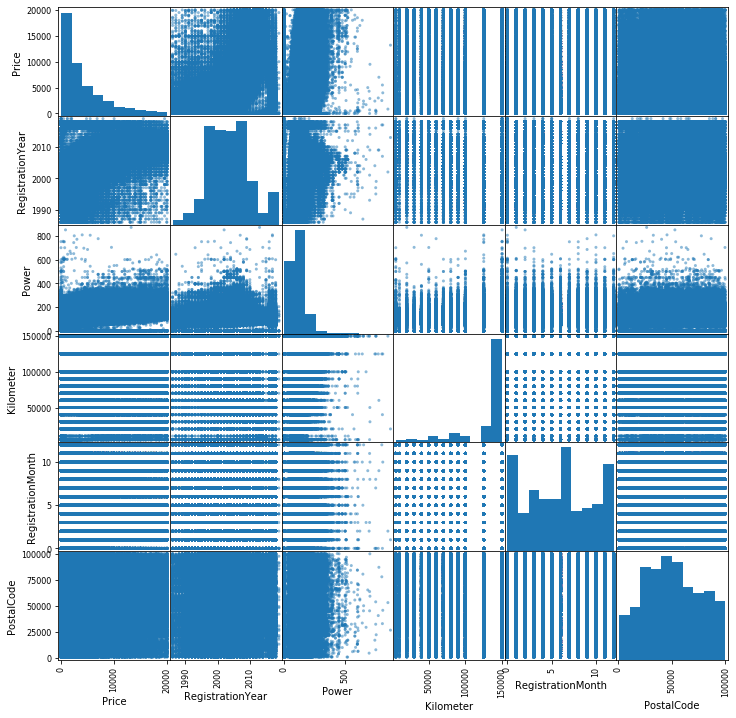

In [24]:
pd.plotting.scatter_matrix(data[['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'PostalCode']], figsize = (12,12))
pass

In [25]:
data.corr()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,0.488320,0.491278,-0.361701,0.098792,NaN,0.073921
RegistrationYear,0.488320,1.000000,0.089262,-0.309844,0.022261,NaN,0.024518
Power,0.491278,0.089262,1.000000,0.062012,0.107811,NaN,0.073025
Kilometer,-0.361701,-0.309844,0.062012,1.000000,-0.008227,NaN,-0.011972
RegistrationMonth,0.098792,0.022261,0.107811,-0.008227,1.000000,NaN,0.010849
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.073921,0.024518,0.073025,-0.011972,0.010849,NaN,1.000000


***Вывод***

Есть заметные корреляции между некоторыми признаками, однако недостаточные, чтобы отказаться от любого признака. Хотя корреляции с количеством фото выглядят подозрительно. Посмотрим на этот столбец поближе.

In [26]:
data['NumberOfPictures'].unique()

array([0])

Как мы видим это константный стобец, что говорит нам о его бесполезности. Удалим его.

In [27]:
data = data.drop('NumberOfPictures', axis = 1)
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,other,1993,manual,0,golf,150000,0,petrol,volkswagen,no,2016-03-24 00:00:00,70435,2016-04-07 03:16:57
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,petrol,jeep,no,2016-03-14 00:00:00,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,petrol,skoda,no,2016-03-31 00:00:00,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,33775,2016-04-06 19:17:07


### Приведение типов переменных

In [28]:
data["DateCrawled"] = pd.to_datetime(data["DateCrawled"])
data.loc[data["NotRepaired"] == 'yes', "NotRepaired"] = 1
data.loc[data["NotRepaired"] == 'no', "NotRepaired"] = 0
data["NotRepaired"] = data["NotRepaired"].astype(int) 
data["DateCreated"] = pd.to_datetime(data["DateCreated"])
data["LastSeen"] = pd.to_datetime(data["LastSeen"])

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 329445 entries, 0 to 354368
Data columns (total 15 columns):
DateCrawled          329445 non-null datetime64[ns]
Price                329445 non-null int64
VehicleType          329445 non-null object
RegistrationYear     329445 non-null int64
Gearbox              329445 non-null object
Power                329445 non-null int64
Model                329445 non-null object
Kilometer            329445 non-null int64
RegistrationMonth    329445 non-null int64
FuelType             329445 non-null object
Brand                329445 non-null object
NotRepaired          329445 non-null int64
DateCreated          329445 non-null datetime64[ns]
PostalCode           329445 non-null int64
LastSeen             329445 non-null datetime64[ns]
dtypes: datetime64[ns](3), int64(7), object(5)
memory usage: 40.2+ MB


### Дроп столбцов DateCrawled и LastSeen, как дублирующих счётчиков. Приведение столбца DateCreated  в тип int

In [30]:
data = data.drop("DateCrawled", axis = 1)
data = data.drop("LastSeen", axis = 1)
data["DateCreated"] = data["DateCreated"].astype(int) // 10**11

Алгоритм случайного леса не работает со столбцами datetime, поэтому приведём в int.

### OHE, масштабирование данных и разбиение на выборки

In [31]:
for_transformation = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand']
data = data.reset_index(drop = True)
data_ohe = pd.get_dummies(data, columns = for_transformation, drop_first = True)
data_ohe.head()


encoder = OrdinalEncoder()
data_ordinal = data
data_ordinal[for_transformation] = pd.DataFrame(encoder.fit_transform(data_ordinal[for_transformation]), columns = for_transformation)

In [32]:
target = data_ohe['Price']
features = data_ohe.drop('Price', axis = 1)
features_train_and_valid_ohe, features_test_ohe, target_train_and_valid_ohe, target_test_ohe = train_test_split(
    features, target, test_size=0.2,  random_state=12345)  
print("Размеры обучающей выборки:", len(features_train_and_valid_ohe), len(target_train_and_valid_ohe))
print("Размеры тестовой выборки:", len(features_test_ohe), len(target_test_ohe))

features_train_and_valid_ordinal = data_ordinal.iloc[features_train_and_valid_ohe.index].drop("Price", axis = 1)
target_train_and_valid_ordinal = data_ordinal.iloc[target_train_and_valid_ohe.index]["Price"]

features_test_ordinal = data_ordinal.iloc[features_test_ohe.index]
target_test_ordinal = data_ordinal.iloc[target_test_ohe.index]

Размеры обучающей выборки: 263556 263556
Размеры тестовой выборки: 65889 65889


In [33]:
numeric = ["RegistrationYear", "Power", "Kilometer", "RegistrationMonth", "PostalCode"]

scaler = StandardScaler()
scaler.fit(features_train_and_valid_ohe[numeric])

features_train_and_valid_ohe.loc[:, numeric] = scaler.transform(features_train_and_valid_ohe.loc[:, numeric])
features_test_ohe.loc[:, numeric] = scaler.transform(features_test_ohe.loc[:, numeric])

features_train_and_valid_ordinal.loc[:, numeric] = scaler.transform(features_train_and_valid_ordinal.loc[:, numeric])
features_test_ordinal.loc[:, numeric] = scaler.transform(features_test_ordinal.loc[:, numeric])

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

## Обучение моделей

### Модель случайного леса и линейной регрессии

In [34]:
def rmse(predict, target):
    return mean_squared_error(target, predict) ** .5
    
score = make_scorer(rmse, greater_is_better = False)

In [35]:
results = pd.DataFrame(columns = ["rmse", "time"])
best_model = None
best_result = 10000
best_forest_model = None
best_forest_result = 10000


model = RandomForestRegressor(random_state=12345, n_estimators = 10)

start_time = time.time()
scores = cross_val_score(model, features_train_and_valid_ordinal, target_train_and_valid_ordinal, scoring = score, cv = 3)
end_time = (time.time() - start_time) / 3

final_score =  scores.mean()
new_row = pd.Series(data = {"rmse": int(-final_score), "time": end_time}, name = "RandForest")
results = results.append(new_row, ignore_index = False)

print(final_score)

-1761.3188685620235


In [36]:
model = LinearRegression()

start_time = time.time()
scores = cross_val_score(model, features_train_and_valid_ordinal, target_train_and_valid_ordinal, scoring = score, cv = 3)
end_time = (time.time() - start_time) / 3

final_score =  scores.mean()
new_row = pd.Series(data = {"rmse": int(-final_score), "time": end_time}, name = "LinearReg")
results = results.append(new_row, ignore_index = False)

print(final_score)

-3080.2024992288316


Проверили стандартные модели, чтобы сравнить их с градиентным бустингом.

### LightGBM

#### Создание выборок для бустинга и приведение категориальных признаков к типу 'category',  масштабирование

In [37]:
data['VehicleType'] = data['VehicleType'].astype('category') 
data['Gearbox'] = data['Gearbox'].astype('category')
data['Model'] = data['Model'].astype('category')
data['FuelType'] = data['FuelType'].astype('category')
data['Brand'] = data['Brand'].astype('category')


features_train_and_valid = data.iloc[features_train_and_valid_ohe.index].drop("Price", axis = 1)
target_train_and_valid = data.iloc[target_train_and_valid_ohe.index]["Price"]

features_train, features_valid, target_train, target_valid = train_test_split(
    features_train_and_valid, target_train_and_valid, test_size=0.25,  random_state = 12345) 

features_test = data.iloc[features_test_ohe.index].drop("Price", axis = 1)
target_test = data.iloc[target_test_ohe.index]["Price"]

scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata

#### Бустинг без параметров

In [38]:
%%time
model = LGBMRegressor()

start_time = time.time()
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
score = mean_squared_error(y_true = target_valid, y_pred = predicted_valid) ** 0.5
end_time = time.time() - start_time
new_row = pd.Series(data = {"rmse": int(score), "time": end_time}, name = "NoParamsBoost")
results = results.append(new_row, ignore_index = False)

print(score)

1694.5866936560333
CPU times: user 26.7 s, sys: 217 ms, total: 26.9 s
Wall time: 27.2 s


Если просто запустить градиентный бустинг без параметров, то метод случайного леса лучше.

### Бустинг с подбором параметров

Функция для бустинга с заданными параметрами

In [39]:
def boost(params, features_train, features_valid, target_train, target_valid, results, name):
    train_data = lgbm.Dataset(features_train, target_train)
    valid_data = lgbm.Dataset(features_valid, target_valid)
    
    start_time = time.time()
    model = lgbm.train(params, train_data, valid_sets = valid_data, verbose_eval = params['verbose_eval'])

    predicted_valid = model.predict(features_valid)
    score = mean_squared_error(target_valid, y_pred = predicted_valid) ** 0.5
    end_time = time.time() - start_time
    new_row = pd.Series(data = {"rmse": int(score), "time": end_time}, name = name)
    results = results.append(new_row, ignore_index = False)

    print(score)
    return model, results

#### Бустинг с увеличенным количеством итераций

In [40]:
params = {
    "num_iterations" : 150,
    "metric" : "rmse",
    "learning_rate" : .1,
    "seed" : 12345,
    "verbose_eval" : True
}

In [41]:
%%time
model, results = boost(params, features_train, features_valid, target_train, target_valid, results, "BoostNumIter150")

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 4170.48
[2]	valid_0's rmse: 3882.75
[3]	valid_0's rmse: 3634.23
[4]	valid_0's rmse: 3409.94
[5]	valid_0's rmse: 3212.62
[6]	valid_0's rmse: 3037.52
[7]	valid_0's rmse: 2886.72
[8]	valid_0's rmse: 2752.86
[9]	valid_0's rmse: 2637.04
[10]	valid_0's rmse: 2529.53
[11]	valid_0's rmse: 2438.03
[12]	valid_0's rmse: 2355.71
[13]	valid_0's rmse: 2285.09
[14]	valid_0's rmse: 2224.27
[15]	valid_0's rmse: 2170.13
[16]	valid_0's rmse: 2123.12
[17]	valid_0's rmse: 2082.78
[18]	valid_0's rmse: 2045.72
[19]	valid_0's rmse: 2013.11
[20]	valid_0's rmse: 1984.83
[21]	valid_0's rmse: 1959.74
[22]	valid_0's rmse: 1936.55
[23]	valid_0's rmse: 1915.74
[24]	valid_0's rmse: 1897.54
[25]	valid_0's rmse: 1881.4
[26]	valid_0's rmse: 1867.78
[27]	valid_0's rmse: 1855.85
[28]	valid_0's rmse: 1845.12
[29]	valid_0's rmse: 1832.85
[30]	valid_0's rmse: 1823.28
[31]	valid_0's rmse: 1815.2
[32]	valid_0's rmse: 1806.79
[33]	valid_0's rmse: 1799.73
[34]	valid_0's rmse: 1793.24
[35]	valid_0's rmse: 1786

Можно сделать вывод, что стандартных 100 итераций оказалось недостаточно, однако модель стала медленно обучаться на последних итерациях. Скорее всего стандартный learning rate оптимален, но давайте попробуем его уменьшить и увеличить число итераций.

#### Бустинг с уменьшенным learning rate и 1500 итераций

In [42]:
params = {
    "num_iterations" : 1500,
    "metric" : "rmse",
    "learning_rate" : .01,
    "seed" : 12345,
    "verbose_eval" : True
}

In [43]:
%%time
start_time = time.time()
model, results = boost(params, features_train, features_valid, target_train, target_valid, results, "BoostNumIter1500LearningRate0.01")

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 4461.53
[2]	valid_0's rmse: 4429.07
[3]	valid_0's rmse: 4397.02
[4]	valid_0's rmse: 4365.38
[5]	valid_0's rmse: 4333.94
[6]	valid_0's rmse: 4303.03
[7]	valid_0's rmse: 4272.33
[8]	valid_0's rmse: 4242.13
[9]	valid_0's rmse: 4212.15
[10]	valid_0's rmse: 4182.67
[11]	valid_0's rmse: 4153.4
[12]	valid_0's rmse: 4124.28
[13]	valid_0's rmse: 4095.87
[14]	valid_0's rmse: 4067.53
[15]	valid_0's rmse: 4039.57
[16]	valid_0's rmse: 4011.86
[17]	valid_0's rmse: 3984.46
[18]	valid_0's rmse: 3957.68
[19]	valid_0's rmse: 3930.98
[20]	valid_0's rmse: 3904.52
[21]	valid_0's rmse: 3878.95
[22]	valid_0's rmse: 3853.31
[23]	valid_0's rmse: 3828.34
[24]	valid_0's rmse: 3803.44
[25]	valid_0's rmse: 3778.79
[26]	valid_0's rmse: 3754.68
[27]	valid_0's rmse: 3730.29
[28]	valid_0's rmse: 3706.84
[29]	valid_0's rmse: 3683.17
[30]	valid_0's rmse: 3659.82
[31]	valid_0's rmse: 3637.22
[32]	valid_0's rmse: 3614.42
[33]	valid_0's rmse: 3592.31
[34]	valid_0's rmse: 3570.12
[35]	valid_0's rmse: 354

Уменьшение learning rate практически не дало прироста качества, хотя использовало практически в 10 раз больше времени. Эту модель мы не берём.

#### Бустинг с увеличенным количеством листьев

In [44]:
params = {
    "num_leaves" : 100,
    "metric" : "rmse",
    "learning_rate" : .1,
    "seed" : 12345,
    "verbose_eval" : True
}

In [45]:
%%time
model, results = boost(params, features_train, features_valid, target_train, target_valid, results, "BoostNum_leaves100")

[1]	valid_0's rmse: 4146.99
[2]	valid_0's rmse: 3837.74
[3]	valid_0's rmse: 3566.98
[4]	valid_0's rmse: 3327.24
[5]	valid_0's rmse: 3114.77
[6]	valid_0's rmse: 2931.22
[7]	valid_0's rmse: 2770.01
[8]	valid_0's rmse: 2628.61
[9]	valid_0's rmse: 2505.94
[10]	valid_0's rmse: 2396.83
[11]	valid_0's rmse: 2302.68
[12]	valid_0's rmse: 2222.12
[13]	valid_0's rmse: 2152.95
[14]	valid_0's rmse: 2091.5
[15]	valid_0's rmse: 2039.25
[16]	valid_0's rmse: 1993.88
[17]	valid_0's rmse: 1954.36
[18]	valid_0's rmse: 1920.31
[19]	valid_0's rmse: 1890.12
[20]	valid_0's rmse: 1864.02
[21]	valid_0's rmse: 1841.41
[22]	valid_0's rmse: 1821.68
[23]	valid_0's rmse: 1804.8
[24]	valid_0's rmse: 1789.68
[25]	valid_0's rmse: 1776.88
[26]	valid_0's rmse: 1765.99
[27]	valid_0's rmse: 1755.51
[28]	valid_0's rmse: 1746.03
[29]	valid_0's rmse: 1738.33
[30]	valid_0's rmse: 1731.22
[31]	valid_0's rmse: 1725.04
[32]	valid_0's rmse: 1718.41
[33]	valid_0's rmse: 1713.12
[34]	valid_0's rmse: 1707.86
[35]	valid_0's rmse: 1703

Опять таки видим, что с learning rate всё в порядке. Оставим его в покое, однако увеличение количества листьев дало неплохой прирост, за незначительную прибавку ко времени. Пока это наш лидер.

#### Эксперементы с количеством листьев

In [46]:
params = {
    "num_iterations" : 150,
    "num_leaves" : 100,
    "metric" : "rmse",
    "learning_rate" : .1,
    "seed" : 12345,
    "verbose_eval" : False
}

In [47]:
train_data = lgbm.Dataset(features_train, target_train)
valid_data = lgbm.Dataset(features_valid, target_valid)
for leave in range(40, 210,10):
    params["num_leaves"] = leave
    model = lgbm.train(params, train_data, valid_sets = valid_data, verbose_eval = params['verbose_eval'])
    predicted_valid = model.predict(features_valid)
    result = mean_squared_error(target_valid, y_pred = predicted_valid) ** 0.5
    print(leave)
    print(result)


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


40
1666.0989647250221


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


50
1654.9692743002165


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


60
1645.3808672766029


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


70
1637.4971129012629


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


80
1634.7751155716833


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


90
1631.7104275440402


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


100
1629.2796746289189


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


110
1626.3581867745763


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


120
1622.9163933079158


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


130
1615.7809160185973


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


140
1618.1388206677873


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


150
1613.1491749698673


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


160
1613.429779967278


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


170
1609.3116684734741


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


180
1609.7025605363647


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


190
1607.3087001341296


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


200
1603.1022990584095


In [48]:
%%time
model, results = boost(params, features_train, features_valid, target_train, target_valid, results, "NumIter150BestLeavesBoost")

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


1603.1022990584095
CPU times: user 27.1 s, sys: 172 ms, total: 27.3 s
Wall time: 27.7 s


Мы улучшили метрику на 2,5%, и потеряли во времени в два раза. Но это, и обучение, и предсказание, а модель мы обучаем не так часто, чтобы 35 секунд были критичными 

#### Пробуем ускорить обучение с использованием подвыборок

In [49]:
params["bagging_freq"] = 10
params["bagging_fraction"] = 0.25

In [50]:
%%time
model_fraq, results = boost(params, features_train, features_valid, target_train, target_valid, results, "BoostBaggingfreq10BaggingFraction0.25")

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


1664.4266933007368
CPU times: user 26.3 s, sys: 216 ms, total: 26.5 s
Wall time: 26.9 s


Странные дела... мы проиграли и по скорости и по точности. Эти параметры не трогаем.

In [51]:
params["bagging_freq"] = 0
params["bagging_fraction"] = 1

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> У моделей Catboost и lightGBM существуют внутренние механизмы обработки категориальных признаков. В данном случае нужно использовать их. Более подробную информацию можно найти в интернете.
    <br> Подскажу с lightGBM: достаточно изменить тип колонок с категориальными признаками на соответствующий: .astype('category').
</div>

<div class="alert alert-block alert-success">
<b>Успех (ревью 2):</b> С бустингом все ОК, молодец!
</div>

## Анализ моделей

In [52]:
results

,rmse,time
RandForest,1761.0,9.495611
LinearReg,3080.0,0.259123
NoParamsBoost,1694.0,27.190871
BoostNumIter150,1675.0,54.897633
BoostNumIter1500LearningRate0.01,1672.0,265.636068
BoostNum_leaves100,1641.0,15.611468
NumIter150BestLeavesBoost,1603.0,27.714840
BoostBaggingfreq10BaggingFraction0.25,1664.0,26.791165


Проверим пока только самую лучшую нашу модель, если она предсказывает быстро(в пределах 2-3 секунд), то остальные модели нам не понадобятся.

In [53]:
train_data = lgbm.Dataset(features_train, target_train)
valid_data = lgbm.Dataset(features_valid, target_valid)

In [54]:
%%time
model = lgbm.train(params, train_data, valid_sets = valid_data, verbose_eval = params['verbose_eval'])

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


CPU times: user 24.1 s, sys: 113 ms, total: 24.2 s
Wall time: 24.6 s


In [55]:
%%time
predicted_test = model.predict(features_test)

CPU times: user 1.54 s, sys: 7.59 ms, total: 1.55 s
Wall time: 1.52 s


In [56]:
result = mean_squared_error(target_test, predicted_test) ** 0.5
print(result)

1606.4619298860516


***Вывод***

Наша модель предсказывает практически также хорошо на тестовых данных, как и на валидационных. Это говорит нам о том, что наша модель не переобучилась. Также тренировка модели укладывается в одну минуту. Это вполне нормальная скорость, так как даже если мы по каким-то причинам потеряем модель, то сможем за минуту её вернуть и пользователи скорее всего даже не поймут что случилось(всётаки ситуация с падением модели не такая уж и частая). Также модель делает предсказания меньше, чем за 2 секунды. Это также отличный результат, так как такое время человек способен удерживать внимание, что говорит нам о том, что клиент не уйдёт не дождавшись результата.

### Проверка модели на адекватность

In [57]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train_and_valid_ohe, target_train_and_valid_ohe)
dummy_predict = dummy_regr.predict(features_test_ohe)
dummy_result = mean_squared_error(target_test_ohe, dummy_predict) ** 0.5
print(dummy_result)

4540.591897122182


***Вывод***

Сегодня дядя Вася на глазок не справится. Наша модель лучше, чем простая модель и работает за приемелемое время.